# Time Series

In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [35]:
y_train = pd.read_csv("/Users/salvu/Desktop/DM2Git/3Modulo/Dataset/y_train.txt", header=None, delim_whitespace=True )
body_acc_x_train = pd.read_csv("/Users/salvu/Desktop/DM2Git/3Modulo/Dataset/body_acc_x_train.txt", header=None,  delim_whitespace=True)
body_gyro_z_train = pd.read_csv("/Users/salvu/Desktop/DM2Git/3Modulo/Dataset/body_gyro_z_train.txt", header=None,  delim_whitespace=True)
body_gyro_z_test = pd.read_csv("/Users/salvu/Desktop/DM2Git/3Modulo/Dataset/body_gyro_z_test.txt", header=None,  delim_whitespace=True)

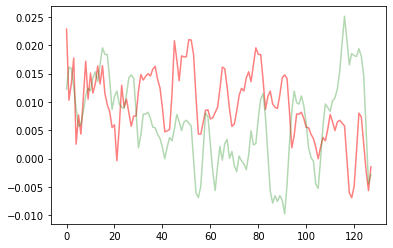

In [26]:
#Fare la trasposta per avere il dataset in cui le colonne sono i timestamp
ts0 = body_gyro_z_train.T[0]
ts1 = body_gyro_z_train.T[1]

plt.plot(ts0, color='r', alpha=0.5)
plt.plot(ts1,color='g', alpha=0.3)
plt.show()

## Trasformation

### Transformation I: Offset Translation

In [10]:
ts_offs=body_gyro_z_train.copy(deep=True)

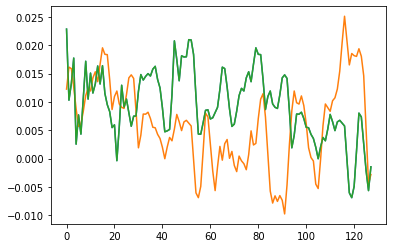

In [5]:
#ts_off=[]
for i in range(0,7352,1):
    ts_offs.T[i] = (ts_offs.T[i] - ts_offs.T[i].mean())

plt.plot(ts_offs.T[0])
plt.plot(ts_offs.T[1])
plt.plot(body_gyro_z_train.T[0])
plt.show()

### Transformation II: Amplitude Scaling

In [11]:
ts_ampl=body_gyro_z_train.copy(deep=True) #copio il dataframe senza modificare l'originale per poi salvare l'amplitude Scaling

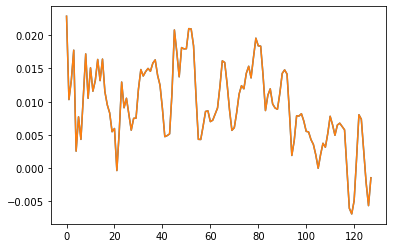

In [7]:
for i in range(0,7352,1):
    ts_ampl.T[i]=(ts_ampl.T[i] - ts_ampl.T[i].mean())/ts_ampl.T[i].std()

plt.plot(ts_ampl.T[0])    
plt.plot(body_gyro_z_train.T[0]) #in arancione, i suoi valori erano nell'intorno dello 0 e ora sono molto amplificati
plt.show()

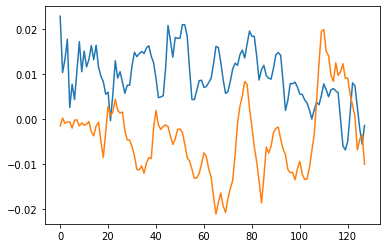

In [8]:
plt.plot(ts_ampl.T[0]) #blu
plt.plot(ts_ampl.T[4]) #arancione
plt.show()

### Transformation IV: Noise (smoothing)


In [12]:
ts_noismot = body_gyro_z_train.copy(deep=True)

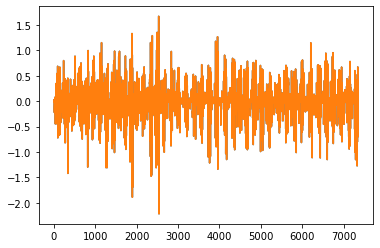

In [16]:
w_noise=10 # regola la rimozione del rumore NB! forse va calibrato in base alle pause spiegate nelle feature info??
#ts_noise=[] 
for i in range(0,7352,1):
    ts_noismot.T[i] = ((ts_noismot.T[i].mean())/(ts_noismot.T[i].std()))
    #ts_noise.append(((ts[i]- ts[i].mean())/ts[i].std()).rolling(window=w_noise).mean())
plt.plot(ts_ampl[0])
plt.plot(ts_noismot[0])
plt.show()

In [18]:
# plt.plot(ts_noise[0])
# plt.plot(ts_noise[1])
# plt.show()

### Transformation III: Trend removal

In [13]:
ts_trend = body_gyro_z_train.copy(deep=True) #NON CONVIENE UTILIZZARLO PERCHE' LASCIA TROPPI NAN

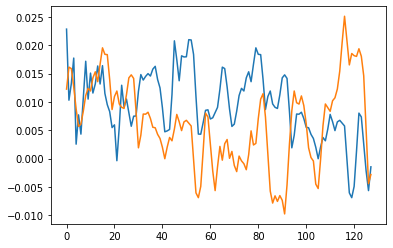

In [20]:
#ts_shift=[]
for i in range(0,7352,1):    # calcola il rolling e prende la media per usarla come trend
    ts_trend.T[i] = ts_trend.T[i] - ts_trend.T[i].rolling(window=12).mean()
    #ts_shift.append(ts[i] - ts[i].rolling(window=12).mean()) # rimuove il trend
plt.plot(ts_trend.T[0])
plt.plot(ts_trend.T[1])
plt.show()

In [21]:
# plt.plot(ts_shift[0])
# plt.plot(ts_shift[1])
# plt.show()

## Features Extraction

In [3]:
#SE DAL DATASET DELLE TIMESERIES VOGLIAMO LAVORARE CON LE FATURES:
#!pip install tsfresh
import numpy as np
import scipy.stats as stats

from tsfresh.feature_extraction import extract_features 
from tsfresh.feature_extraction import ComprehensiveFCParameters

In [25]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [14]:
tsp=body_gyro_z_train.copy(deep=True)

In [31]:
features = calculate_features(tsp[0])
features

{'avg': 0.0031624910471385404,
 'std': 0.2587683124649048,
 'var': 0.0669610395359346,
 'med': 0.00040045360000000004,
 '10p': -0.26902592,
 '25p': -0.03187152,
 '50p': 0.00040045360000000004,
 '75p': 0.0635290775,
 '90p': 0.2928283400000001,
 'iqr': 0.0954005975,
 'cov': 0.01222132268442818,
 'skw': -0.5192640088762154,
 'kur': 6.07174053577973}

In [32]:
tsp['id'] = [0] * len(tsp) # crea un id altimenti non  gli funziona # non so se a noi serve

In [4]:
settings = ComprehensiveFCParameters()
# del settings['matrix_profile']

In [34]:
## per estrarre una serie di features preimpostate
features = extract_features(timeseries_container=tsp, 
                            column_id='id', 
                            default_fc_parameters=settings)

Feature Extraction:   0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
features.to_dict() # calcola features # attento molte sono null

## Approximations (TS Dimensionality_Reduction)

### Trasformazione di Fourier

In [5]:
!!pip install pyts
from pyts.approximation import DiscreteFourierTransform # consigliata se la Time Series presenta una forma naturale, altrimenti usi la PAA

In [15]:
n_coefs = 64 
ts_off1=pd.DataFrame(tsp)
dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts1_dft = dft.fit_transform(ts_off1.values.reshape(1, -1)) # trasforma da una colonna a una riga e 64 colonne

In [16]:
ts1_dft = pd.DataFrame(ts1_dft)
ts1_dft

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,106.290806,1355.327665,1218.665027,-374.833406,58.616054,-1429.873919,28.476403,-266.521534,-108.361888,26.318679,...,57.924147,150.337204,139.120995,-430.264109,247.889188,342.191748,-358.523617,272.75192,-601.586545,-163.84396


In [23]:
#Inverse Transform
a=np.fft.ifft(ts1_dft, n=None, axis=-1, norm=None)
# ts1_dft_inv = dft.inverse_trasform(ts1_dft, n_coefs=n_coefs, n_timestamps=len(ts1.values))
# ts1_dft_inv

c:\anaconda3n\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<function matplotlib.pyplot.show(close=None, block=None)>

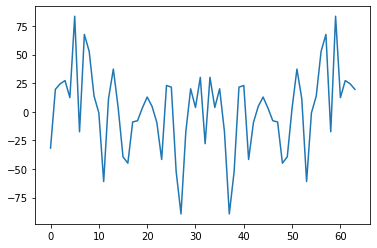

In [24]:
plt.plot(a.ravel()) # timeseries dopo la trasformazione di fourier ma prima di fare l'inverso
plt.show

c:\anaconda3n\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


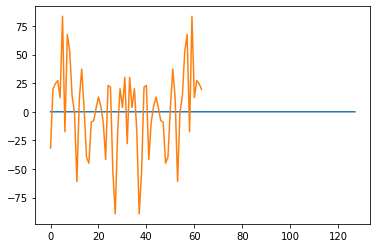

In [27]:
plt.plot(ts1.ravel()) # originale
plt.plot(a.ravel()) # dopo l'approssimazione di Fourier invertita
plt.show()

### Trasformazione SVD

In [28]:
from sklearn.decomposition import TruncatedSVD

In [29]:
svd = TruncatedSVD(n_components=2) # numero di componenti che gli passi
ts1_svd = svd.fit_transform(ts1.values.reshape(1, -1))
#ts_svd = svd.fit_transform(np.array([ts.values.reshape(1, -1)[0], 
#                                     ts.values.reshape(1, -1)[0]]))

c:\anaconda3n\lib\site-packages\sklearn\decomposition\_truncated_svd.py:268: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [30]:
ts1_svd_inv = svd.inverse_transform(ts1_svd)[0]
ts1_svd_inv

array([ 1.226815e-02,  1.614958e-02,  1.589471e-02,  1.267118e-02,
        8.774044e-03,  5.685091e-03,  6.092832e-03,  8.383453e-03,
        1.113997e-02,  1.240639e-02,  1.194220e-02,  1.425919e-02,
        1.532931e-02,  1.358108e-02,  1.666432e-02,  1.955620e-02,
        1.841148e-02,  1.835649e-02,  1.396835e-02,  8.665903e-03,
        1.096347e-02,  1.193223e-02,  9.651963e-03,  9.057493e-03,
        8.856516e-03,  1.126824e-02,  1.425713e-02,  1.478594e-02,
        1.415870e-02,  8.383668e-03,  1.907059e-03,  4.132293e-03,
        7.871423e-03,  7.842663e-03,  8.190243e-03,  7.085829e-03,
        5.537530e-03,  5.446472e-03,  4.285669e-03,  3.559909e-03,
        2.001571e-03, -1.681245e-05,  2.037589e-03,  3.736043e-03,
        3.147507e-03,  5.214139e-03,  7.802100e-03,  6.516378e-03,
        4.947088e-03,  6.478854e-03,  6.763766e-03,  6.273074e-03,
        5.763410e-03, -2.357261e-05, -6.041726e-03, -6.890512e-03,
       -4.902893e-03,  1.353933e-03,  8.032537e-03,  7.355378e

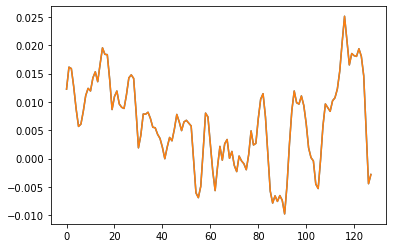

In [31]:
plt.plot(ts1.ravel()) # per una sigola time series ottieni una sovrapposizione perfetta

plt.plot(ts1_svd_inv.ravel())
plt.show()

## -- Più utilizzate --

### PieceAggregateApproximation (PAA)

In [63]:
#!pip install tslearn
from tslearn.piecewise import PiecewiseAggregateApproximation # Questa è consigliata se la TS non ha una forma naturale, altrimenti usi la Trasformazione di Fourier
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation 
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [114]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series # Normalizza una riga
ts0 = body_acc_x_train.T[0]
ts1 = body_acc_x_train.T[1]
ts2 = body_acc_x_train.T[2]

ts0 = scaler.fit_transform(ts0.values.reshape(1,-1))
ts1 = scaler.fit_transform(ts1.values.reshape(1,-1))
ts2 = scaler.fit_transform(ts2.values.reshape(1,-1))

In [117]:
# PAA transform (and inverse transform) of the data
n_paa_segments = 10                                         # sarebbe quella che nelle slides chiama "N" ( e a lezione"k")
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts0_paa = paa.fit_transform(ts0)                              # fit transform

#paa_dataset_inv = paa.inverse_transform(ts0_paa)             # inverse transform

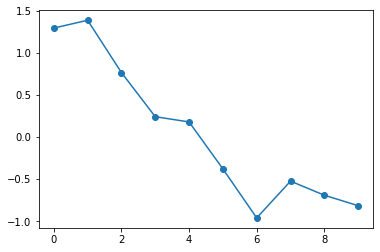

In [118]:
plt.plot(ts0_paa.ravel(), marker='o')  # se ha un andamento decrescente ci fa capire che ha un trend decrescente
plt.show()                             # se ha un andamento crescente ci fa capire che ha un trend crescente
                                        # i punti rappresentano i valori medio dei 10 punti (n_paa_segments) che approssimano
                                        # la time series

In [ ]:
plt.plot(paa_dataset_inv.ravel()) # qui vediamo la l'inverse trasformation e ogni box
plt.show()                     # ogni box ha come valore quelli dati da print(ts0_paa)

In [ ]:
# Se sovrapponiamo alla precedente, l'originale
plt.plot(paa_dataset_inv.ravel()) # qui vediamo la l'inverse trasformation e ogni box # questa è la ricostruzione dopo la compressione
plt.plot(ts0.ravel()) # l'originale
plt.show()

### Symbolic Aggregate Approximation (SAX)

In [67]:
ts= body_gyro_z_train.copy(deep=True)
ts.T[1] #con la trasposta vado a considerara l'intera riga, Serie Temp.

0      0.012268
1      0.016150
2      0.015895
3      0.012671
4      0.008774
         ...   
123    0.018070
124    0.014628
125    0.005045
126   -0.004424
127   -0.002798
Name: 1, Length: 128, dtype: float64

In [68]:
#normalizz
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series # Normalizza una riga
ts_norm = scaler.fit_transform(ts)
ts_norm.shape

(7352, 128, 1)

In [119]:
#SAX
n_sax_symbols = 4
sax = SymbolicAggregateApproximation(n_segments=32,  #numero di segmenti
                                     alphabet_size_avg=n_sax_symbols) # parametro grandezza alfabeto
ts_sax_norm=sax.fit_transform(ts_norm)
#ts_sax_inv = sax.inverse_transform(ts_sax_norm)

In [ ]:
plt.plot(ts_norm[0], label='grezza')
plt.plot(ts_sax_inv[0], label='SAX')
plt.legend(loc='best')
plt.show

In [ ]:
# mostro differenza tra PAA e SAX
plt.plot(paa_dataset_inv.ravel())
plt.plot(sax_dataset_inv.ravel()) # nota ogni segmento del PAA corrisponde a un numero di SAX (perché abbaimo usato lo stesso numero di componenti)
plt.show()

In [ ]:
plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(ts0[0].ravel(), "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(ts0[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(ts0[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(ts0[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

#### PAA vs SAX

In [120]:
# PAA

ts1_paa = paa.fit_transform(ts1)
ts2_paa = paa.fit_transform(ts2)

In [122]:
plt.plot(paa.inverse_transform(ts1_paa)[0].ravel())
plt.plot(paa.inverse_transform(ts2_paa)[0].ravel())
plt.show()

In [ ]:
# SAX

ts1_sax = sax.fit_transform(ts1)
ts2_sax = sax.fit_transform(ts2)

In [ ]:
plt.plot(sax.inverse_transform(ts1_sax)[0].ravel())
plt.plot(sax.inverse_transform(ts2_sax)[0].ravel())
plt.show()

# Clustering

## TimeSeriesKMeans

In [123]:
from tslearn.clustering import TimeSeriesKMeans # ti permette di usare il tipo distanza che vuoi (euclidian,...)
from tslearn.generators import random_walks
from sklearn.metrics import silhouette_score
from tqdm import tqdm

In [124]:
# Run KMeans and plot the results to choose best K
def get_kmeans_results(data, max_clusters=15, metric='dtw', n_jobs=-1):
    sse = []
    silhouette = []
    clusters_range = range(2, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=n_jobs, max_iter=10, random_state=42)
        kmeans_model.fit(data) 
        sse.append(kmeans_model.inertia_)
        silhouette.append(silhouette_score(data, kmeans_model.labels_))
            
# Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[0:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette');            

In [125]:
#da utilizzare in caso di SAX fornendo il numero di segmenti come numero di cols
ts_sax_norm=ts_sax_norm.reshape(7352,32)
ts_sax_norm

array([[3, 1, 3, ..., 0, 0, 0],
       [3, 2, 3, ..., 3, 3, 1],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [2, 2, 3, ..., 3, 2, 2],
       [2, 2, 3, ..., 1, 1, 2],
       [2, 2, 3, ..., 3, 1, 0]])

100%|██████████| 9/9 [00:24<00:00,  2.72s/it]


CPU times: total: 44.4 s
Wall time: 24.5 s


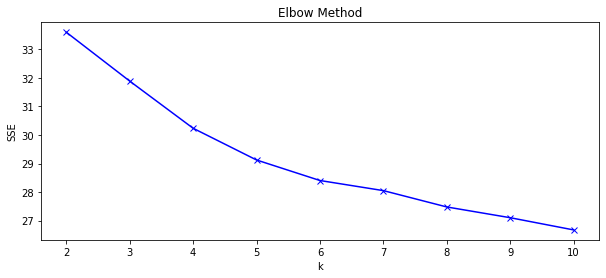

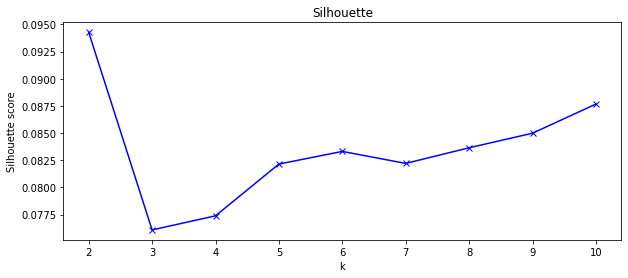

In [126]:
%%time
X=ts_sax_norm
get_kmeans_results(data=X, max_clusters=10, metric='euclidean', n_jobs=-1)

In [127]:
#X=total_acc_z_train
km = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10, random_state=42) # distanza euclidea
km.fit(X)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=6, random_state=42)

In [128]:
#DISTRIBUZIONE CLASSI NEI CLUSTER
pclass_xt = pd.crosstab(km.labels_, y_train[0])
pclass_xt

,1,2,3,4,5,6
row_0,,,,,,
0,126,398,96,224,304,194
1,414,109,395,115,147,194
2,128,300,76,242,306,168
3,11,102,36,370,245,452
4,0,31,7,223,190,183
5,547,133,376,112,182,216


In [129]:
#conteggio TS per cluster
unique, counts = np.unique(km.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 1342, 1: 1374, 2: 1220, 3: 1216, 4: 634, 5: 1566}

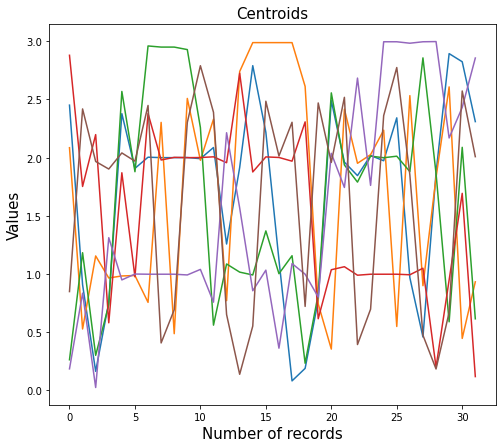

In [130]:
#PLOT CENTROIDI
#sp_names = ['1', '2', '3','4','5','6']
#plt.legend(labels=sp_names, title="Clusters", fontsize = 10)
plt.figure(figsize=(8,7))
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.title('Centroids', size=15)
plt.xlabel("Number of records", size=15)
plt.ylabel("Values", size=15)
plt.show()

In [131]:
print('SSE: ',km.inertia_)
print('Silhouette score: ',silhouette_score(body_gyro_z_train, km.labels_))

SSE:  9.339351124623128
Silhouette score:  -0.26076027873807556


## Approximated Clustering

In [132]:
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(ts)

c:\anaconda3n\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7352 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


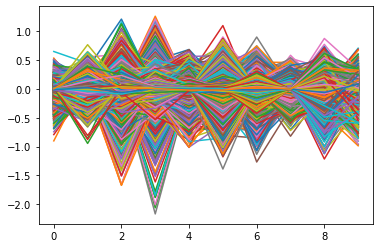

In [133]:
plt.plot(ts_paa.reshape(ts_paa.shape[1], ts_paa.shape[0]))
plt.show()

In [134]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(ts_paa)

TimeSeriesKMeans(max_iter=5, random_state=0)

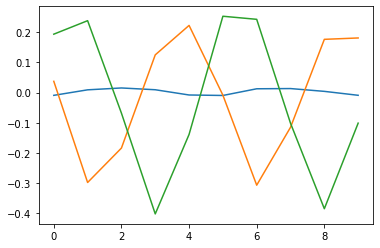

In [135]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [136]:
km.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

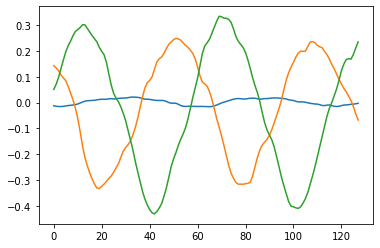

In [137]:
for i in range(3):
    plt.plot(np.mean(np.array(ts)[np.where(km.labels_ == i)[0]], axis=0))
plt.show()